In [1]:
## Tested using the following loaded modules
## module use /g/data/access/ngm/modules
## module load analysis3/21.10
import os, sys
workdir = "/g/data/xv83/users/bxn599/ACS/evaluation/"
os.chdir(workdir)
sys.path.append("./lib")
import glob
import xarray as xr
import numpy as np
import geopandas as gp
from datetime import datetime as dt
import lib_standards
import lib_spatial
import spatial_selection
import matplotlib as mpl
import matplotlib.pyplot as plt
import importlib
importlib.reload(lib_standards)
import warnings
warnings.filterwarnings('ignore')

font = {'size'   : 12}
mpl.rc('font', **font)

In [2]:
DATA_LOCATIONS_HIST = {
    'BARPA-R:ACCESS-CM2': "/g/data/xv83/users/bxn599/ACS/icclim_indices/AUS-15/BOM/CSIRO-ARCCSS-ACCESS-CM2/historical/r4i1p1f1/BOM-BARPA-R/v1/climdex",
    'BARPA-R:ACCESS-ESM1-5': "/g/data/xv83/users/bxn599/ACS/icclim_indices/AUS-15/BOM/CSIRO-ACCESS-ESM1-5/historical/r6i1p1f1/BOM-BARPA-R/v1/climdex",
    'BARPA-R:CESM2': "/g/data/xv83/users/bxn599/ACS/icclim_indices/AUS-15/BOM/NCAR-CESM2/historical/r11i1p1f1/BOM-BARPA-R/v1/climdex",
    'BARPA-R:CMCC-ESM2': "/g/data/xv83/users/bxn599/ACS/icclim_indices/AUS-15/BOM/CMCC-CMCC-ESM2/historical/r1i1p1f1/BOM-BARPA-R/v1/climdex",
    'BARPA-R:CNRM-ESM2-1': "", # not downscaled by BoM
    'BARPA-R:EC-Earth3': "/g/data/xv83/users/bxn599/ACS/icclim_indices/AUS-15/BOM/EC-Earth-Consortium-EC-Earth3/historical/r1i1p1f1/BOM-BARPA-R/v1/climdex",
    'BARPA-R:MPI-ESM1-2-HR': "", # post processing in progress
    'BARPA-R:NorESM2-MM': "/g/data/xv83/users/bxn599/ACS/icclim_indices/AUS-15/BOM/NCC-NorESM2-MM/historical/r1i1p1f1/BOM-BARPA-R/v1/climdex",
    'CMIP6:ACCESS-CM2': "/g/data/xv83/users/bxn599/ACS/icclim_indices/GLOBAL-gn/none/CSIRO-ARCCSS-ACCESS-CM2/historical/r4i1p1f1/none/none/climdex",
    'CMIP6:ACCESS-ESM1-5': "/g/data/xv83/users/bxn599/ACS/icclim_indices/GLOBAL-gn/none/CSIRO-ACCESS-ESM1-5/historical/r6i1p1f1/none/none/climdex",
    'CMIP6:CESM2': "/g/data/xv83/users/bxn599/ACS/icclim_indices/GLOBAL-gn/none/NCAR-CESM2/historical/r11i1p1f1/none/none/climdex",
    'CMIP6:CMCC-ESM2': "/g/data/xv83/users/bxn599/ACS/icclim_indices/GLOBAL-gn/none/CMCC-CMCC-ESM2/historical/r1i1p1f1/none/none/climdex",
    'CMIP6:CNRM-ESM2-1': "/g/data/xv83/users/bxn599/ACS/icclim_indices/GLOBAL-gn/none/CNRM-CERFACS-CNRM-ESM2-1/historical/r1i1p1f2/none/none/climdex",
    'CMIP6:EC-Earth3': "/g/data/xv83/users/bxn599/ACS/icclim_indices/GLOBAL-gn/none/EC-Earth-Consortium-EC-Earth3/historical/r1i1p1f1/none/none/climdex",
    'CMIP6:MPI-ESM1-2-HR': "/g/data/xv83/users/bxn599/ACS/icclim_indices/GLOBAL-gn/none/MPI-M-MPI-ESM1-2-HR/historical/r1i1p1f1/none/none/climdex",
    'CMIP6:NorESM2-MM': "/g/data/xv83/users/bxn599/ACS/icclim_indices/GLOBAL-gn/none/NCC-NorESM2-MM/historical/r1i1p1f1/none/none/climdex",
    'CCAM:ACCESS-CM2': "", # not yet post processed
    'CCAM:ACCESS-ESM1-5': "", # not yet post processed
    'CCAM:CESM2': "", # not yet post processed
    'CCAM:CMCC-ESM2': "", # not yet post processed
    'CCAM:CNRM-ESM2-1': "", # not yet post processed
    'CCAM:EC-Earth3': "/g/data/xv83/users/bxn599/ACS/icclim_indices/AUS-10/CSIRO/EC-Earth-Consortium-EC-Earth3/historical/r1i1p1f1/CSIRO-CCAM-2203/v1/climdex",
    'CCAM:MPI-ESM1-2-HR': "", # not yet run
    'CCAM:NorESM2-MM': "/g/data/xv83/users/bxn599/ACS/icclim_indices/AUS-10/CSIRO/NCC-NorESM2-MM/historical/r1i1p1f1/CSIRO-CCAM-2203/v1/climdex",
}
DATA_LOCATIONS_FUT = {
    'BARPA-R:ACCESS-CM2': "/g/data/xv83/users/bxn599/ACS/icclim_indices/AUS-15/BOM/CSIRO-ARCCSS-ACCESS-CM2/ssp126/r4i1p1f1/BOM-BARPA-R/v1/climdex",
    'BARPA-R:ACCESS-ESM1-5': "/g/data/xv83/users/bxn599/ACS/icclim_indices/AUS-15/BOM/CSIRO-ACCESS-ESM1-5/ssp126/r6i1p1f1/BOM-BARPA-R/v1/climdex",
    'BARPA-R:CESM2': "/g/data/xv83/users/bxn599/ACS/icclim_indices/AUS-15/BOM/NCAR-CESM2/ssp126/r11i1p1f1/BOM-BARPA-R/v1/climdex",
    'BARPA-R:CMCC-ESM2': "/g/data/xv83/users/bxn599/ACS/icclim_indices/AUS-15/BOM/CMCC-CMCC-ESM2/ssp126/r1i1p1f1/BOM-BARPA-R/v1/climdex",
    'BARPA-R:CNRM-ESM2-1': "", # not downscaled by BoM
    'BARPA-R:EC-Earth3': "/g/data/xv83/users/bxn599/ACS/icclim_indices/AUS-15/BOM/EC-Earth-Consortium-EC-Earth3/ssp126/r1i1p1f1/BOM-BARPA-R/v1/climdex",
    'BARPA-R:MPI-ESM1-2-HR': "", # post processing in progress
    'BARPA-R:NorESM2-MM': "/g/data/xv83/users/bxn599/ACS/icclim_indices/AUS-15/BOM/NCC-NorESM2-MM/ssp126/r1i1p1f1/BOM-BARPA-R/v1/climdex", # post processing in progress
    'CMIP6:ACCESS-CM2': "/g/data/xv83/users/bxn599/ACS/icclim_indices/GLOBAL-gn/none/CSIRO-ARCCSS-ACCESS-CM2/ssp126/r4i1p1f1/none/none/climdex",
    'CMIP6:ACCESS-ESM1-5': "/g/data/xv83/users/bxn599/ACS/icclim_indices/GLOBAL-gn/none/CSIRO-ACCESS-ESM1-5/ssp126/r6i1p1f1/none/none/climdex",
    'CMIP6:CESM2': "/g/data/xv83/users/bxn599/ACS/icclim_indices/GLOBAL-gn/none/NCAR-CESM2/ssp126/r11i1p1f1/none/none/climdex",
    'CMIP6:CMCC-ESM2': "/g/data/xv83/users/bxn599/ACS/icclim_indices/GLOBAL-gn/none/CMCC-CMCC-ESM2/ssp126/r1i1p1f1/none/none/climdex",
    'CMIP6:CNRM-ESM2-1': "/g/data/xv83/users/bxn599/ACS/icclim_indices/GLOBAL-gn/none/CNRM-CERFACS-CNRM-ESM2-1/ssp126/r1i1p1f2/none/none/climdex",
    'CMIP6:EC-Earth3': "/g/data/xv83/users/bxn599/ACS/icclim_indices/GLOBAL-gn/none/EC-Earth-Consortium-EC-Earth3/ssp126/r1i1p1f1/none/none/climdex",
    'CMIP6:MPI-ESM1-2-HR': "/g/data/xv83/users/bxn599/ACS/icclim_indices/GLOBAL-gn/none/MPI-M-MPI-ESM1-2-HR/ssp126/r1i1p1f1/none/none/climdex",
    'CMIP6:NorESM2-MM': "/g/data/xv83/users/bxn599/ACS/icclim_indices/GLOBAL-gn/none/NCC-NorESM2-MM/ssp126/r1i1p1f1/none/none/climdex",
    'CCAM:ACCESS-CM2': "", # not yet post processed
    'CCAM:ACCESS-ESM1-5': "", # not yet post processed
    'CCAM:CESM2': "", # not yet post processed
    'CCAM:CMCC-ESM2': "", # not yet post processed
    'CCAM:CNRM-ESM2-1': "", # not yet post processed
    'CCAM:EC-Earth3': "/g/data/xv83/users/bxn599/ACS/icclim_indices/AUS-10/CSIRO/EC-Earth-Consortium-EC-Earth3/ssp126/r1i1p1f1/CSIRO-CCAM-2203/v1/climdex",
    'CCAM:MPI-ESM1-2-HR': "", # not yet run
    'CCAM:NorESM2-MM': "/g/data/xv83/users/bxn599/ACS/icclim_indices/AUS-10/CSIRO/NCC-NorESM2-MM/ssp126/r1i1p1f1/CSIRO-CCAM-2203/v1/climdex",
}
# Frequency of icclim indicator
FREQ = 'month'
# Data sources to consider here
# SOURCES_HIST = ['CMIP6:ACCESS-CM2', 'BARPA-R:ACCESS-CM2', 'CCAM:ACCESS-CM2', \
#                 'CMIP6:ACCESS-ESM1-5', 'BARPA-R:ACCESS-ESM1-5', 'CCAM:ACCESS-ESM1-5', \
#                 'CMIP6:CESM2', 'BARPA-R:CESM2', \ #'CCAM:CESM2', \
#                 'CMIP6:CMCC-ESM2', 'BARPA-R:CMCC-ESM2', 'CCAM:CMCC-ESM2' \
#                 'CMIP6:CNRM-ESM2-1', 'CCAM:CNRM-ESM2-1', \ # 'BARPA-R:CNRM-ESM2-1',
#                 'CMIP6:EC-Earth3', 'BARPA-R:EC-Earth3', 'CCAM:EC-Earth3', \
#                 'CMIP6:MPI-ESM1-2-HR', 'BARPA-R:MPI-ESM1-2-HR', \ #'CCAM:MPI-ESM1-2-HR', \
#                 'CMIP6:NorESM2-MM', 'BARPA-R:NorESM2-MM', 'CCAM:NorESM2-MM']

SOURCES_HIST = ['CMIP6:ACCESS-CM2', 'BARPA-R:ACCESS-CM2', 'CMIP6:ACCESS-ESM1-5', 'BARPA-R:ACCESS-ESM1-5', \
                'CMIP6:CMCC-ESM2', 'CMIP6:EC-Earth3', 'BARPA-R:EC-Earth3', 'CCAM:EC-Earth3', \
                'CMIP6:NorESM2-MM', 'CCAM:NorESM2-MM']

SOURCES_FUT = SOURCES_HIST

# Grid to used as the reference grid to compute difference metrics
REFERENCE_GRID = 'CCAM:NorESM2-MM'
# "Truth" for compute difference metrics
REFERENCE = 'AGCD'
# Region of interest, as per defined in lib_standards.DOMAINS
REGION = 'Australia'  
# Period of interest, as per defined in lib_standards.PERIODS
EARLYPERIOD = 'ACS_HISTORICAL' 
LATEPERIOD = 'ACS_FUTURE_MID'
SEASON='all'

In [3]:
def prepare_data_hist(index, sources=SOURCES_HIST, freq=FREQ, region=REGION, period=EARLYPERIOD, reference_grid=REFERENCE_GRID, season=SEASON):
    """
    Reads in the icclim data and regrid to the reference grid.
    """
    # Load the data sources
    ds = {}
    for s in sources:
        #print("Reading the data {:}".format(s))
        fs = glob.glob(os.path.join(DATA_LOCATIONS_HIST[s], index, "{index}_*_{freq}_*.nc".format(index=index, freq=freq)))
        #print(fs)
        ds[s] = xr.open_dataset(fs[0])
        ds[s] = lib_standards.standardise_data(ds[s], region=region, period=period, season=season, compute=True)

    # Regrid to the REFERENCE_GRID
    ds_regrid = {}
    for s in sources:
        #print("Regridding the data {:} to reference grid of {:}".format(s, reference_grid))
        #ds_regrid[s] = lib_spatial.add_region_land_mask(ds[s], region)
        ds_regrid[s] = ds[s]
        # don't regrid data
#        if s == reference_grid:
#            ds_regrid[s] = ds_regrid[s].compute()
#        else:
#            ds_regrid[s] = lib_standards.regrid(ds_regrid[s], ds[reference_grid]).compute()
    return ds_regrid

In [4]:
def prepare_data_fut(index, sources=SOURCES_FUT, freq=FREQ, region=REGION, period=LATEPERIOD, reference_grid=REFERENCE_GRID, season=SEASON):
    """
    Reads in the icclim data and regrid to the reference grid.
    """
    # Load the data sources
    ds = {}
    for s in sources:
        #print("Reading the data {:}".format(s))
        fs = glob.glob(os.path.join(DATA_LOCATIONS_FUT[s], index, "{index}_*_{freq}_*.nc".format(index=index, freq=freq)))
        #print(fs[0])
        ds[s] = xr.open_dataset(fs[0])
        ds[s] = lib_standards.standardise_data(ds[s], region=region, period=period, season=season, compute=True)

    # Regrid to the REFERENCE_GRID
    ds_regrid = {}
    for s in sources:
        #print("Regridding the data {:} to reference grid of {:}".format(s, reference_grid))
        #ds_regrid[s] = lib_spatial.add_region_land_mask(ds[s], region)
        ds_regrid[s] = ds[s]
        # don't regrid data
#        if s == reference_grid:
#            ds_regrid[s] = ds_regrid[s].compute()
#        else:
#            ds_regrid[s] = lib_standards.regrid(ds_regrid[s], ds[reference_grid]).compute()
    return ds_regrid

index = PRCPTOT
CMIP6:ACCESS-CM2 CMIP6:ACCESS-CM2
BARPA-R:ACCESS-CM2 BARPA-R:ACCESS-CM2
CMIP6:ACCESS-ESM1-5 CMIP6:ACCESS-ESM1-5
BARPA-R:ACCESS-ESM1-5 BARPA-R:ACCESS-ESM1-5
CMIP6:CMCC-ESM2 CMIP6:CMCC-ESM2
CMIP6:EC-Earth3 CMIP6:EC-Earth3
BARPA-R:EC-Earth3 BARPA-R:EC-Earth3
CCAM:EC-Earth3 CCAM:EC-Earth3
CMIP6:NorESM2-MM CMIP6:NorESM2-MM
CCAM:NorESM2-MM CCAM:NorESM2-MM
False
index = PRCPTOT:DJF
CMIP6:ACCESS-CM2 CMIP6:ACCESS-CM2
BARPA-R:ACCESS-CM2 BARPA-R:ACCESS-CM2
CMIP6:ACCESS-ESM1-5 CMIP6:ACCESS-ESM1-5
BARPA-R:ACCESS-ESM1-5 BARPA-R:ACCESS-ESM1-5
CMIP6:CMCC-ESM2 CMIP6:CMCC-ESM2
CMIP6:EC-Earth3 CMIP6:EC-Earth3
BARPA-R:EC-Earth3 BARPA-R:EC-Earth3
CCAM:EC-Earth3 CCAM:EC-Earth3
CMIP6:NorESM2-MM CMIP6:NorESM2-MM
CCAM:NorESM2-MM CCAM:NorESM2-MM
False
index = PRCPTOT:JJA
CMIP6:ACCESS-CM2 CMIP6:ACCESS-CM2
BARPA-R:ACCESS-CM2 BARPA-R:ACCESS-CM2
CMIP6:ACCESS-ESM1-5 CMIP6:ACCESS-ESM1-5
BARPA-R:ACCESS-ESM1-5 BARPA-R:ACCESS-ESM1-5
CMIP6:CMCC-ESM2 CMIP6:CMCC-ESM2
CMIP6:EC-Earth3 CMIP6:EC-Earth3
BARPA-R:

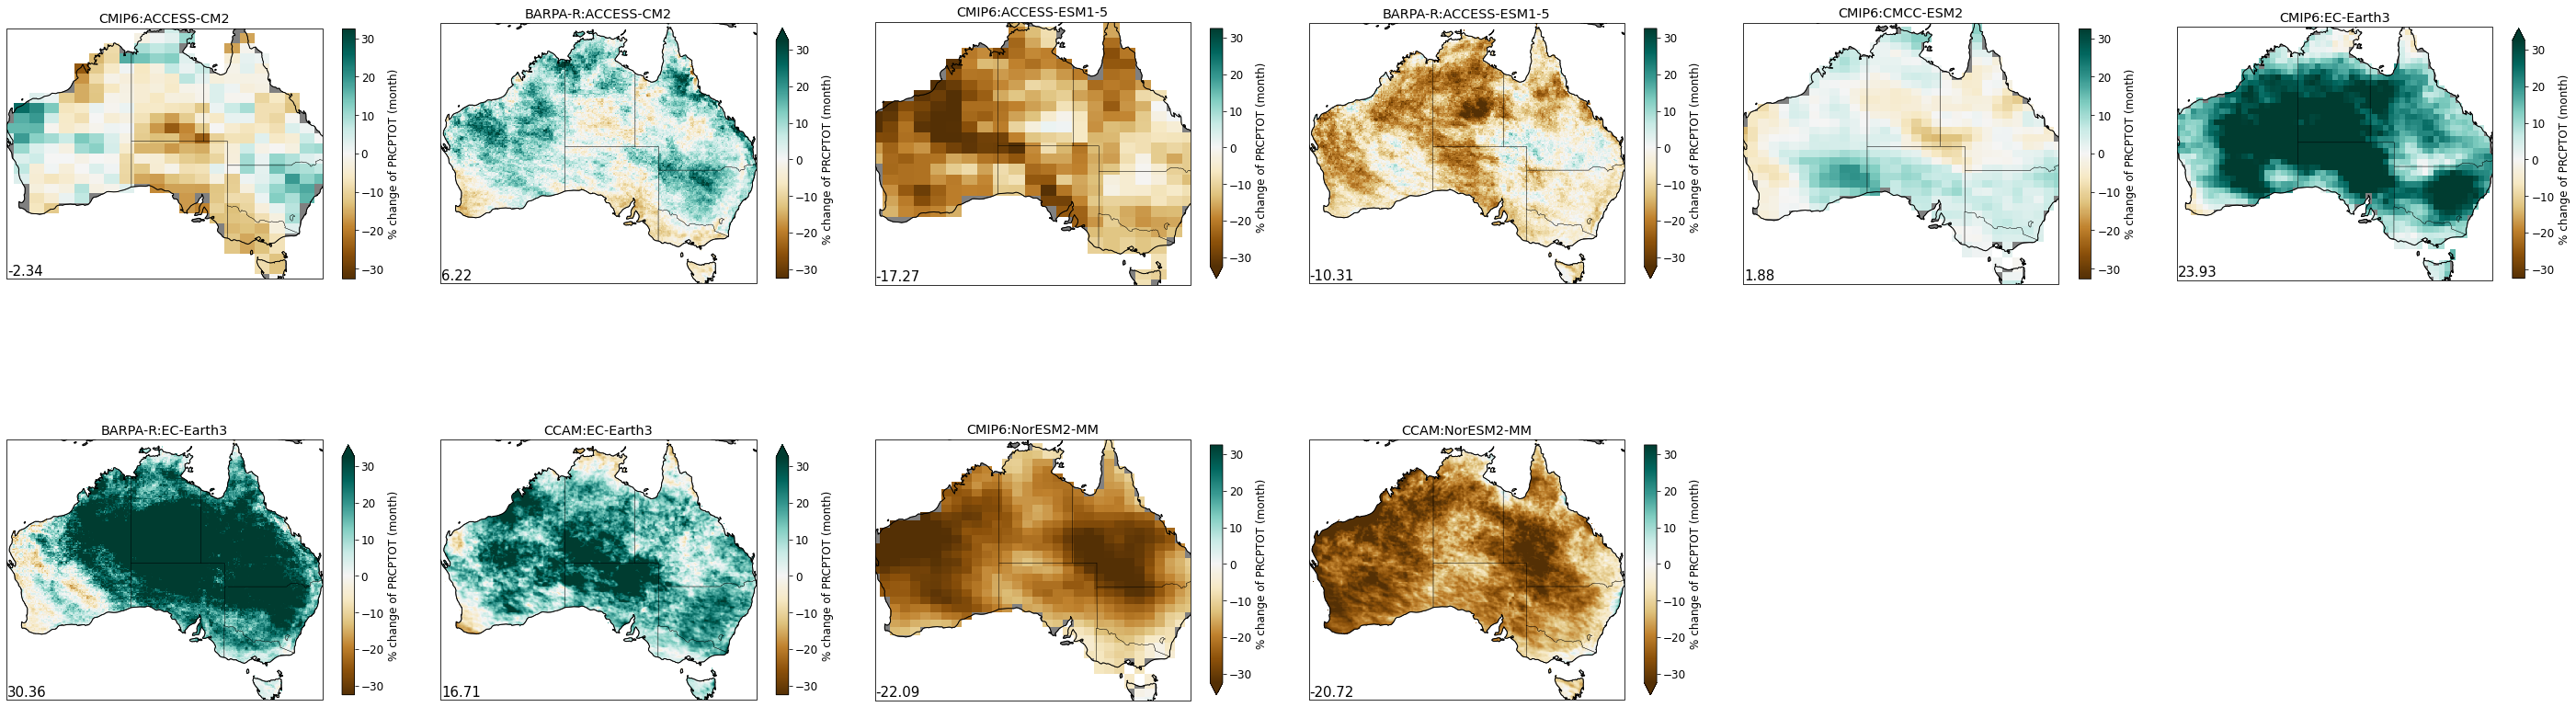

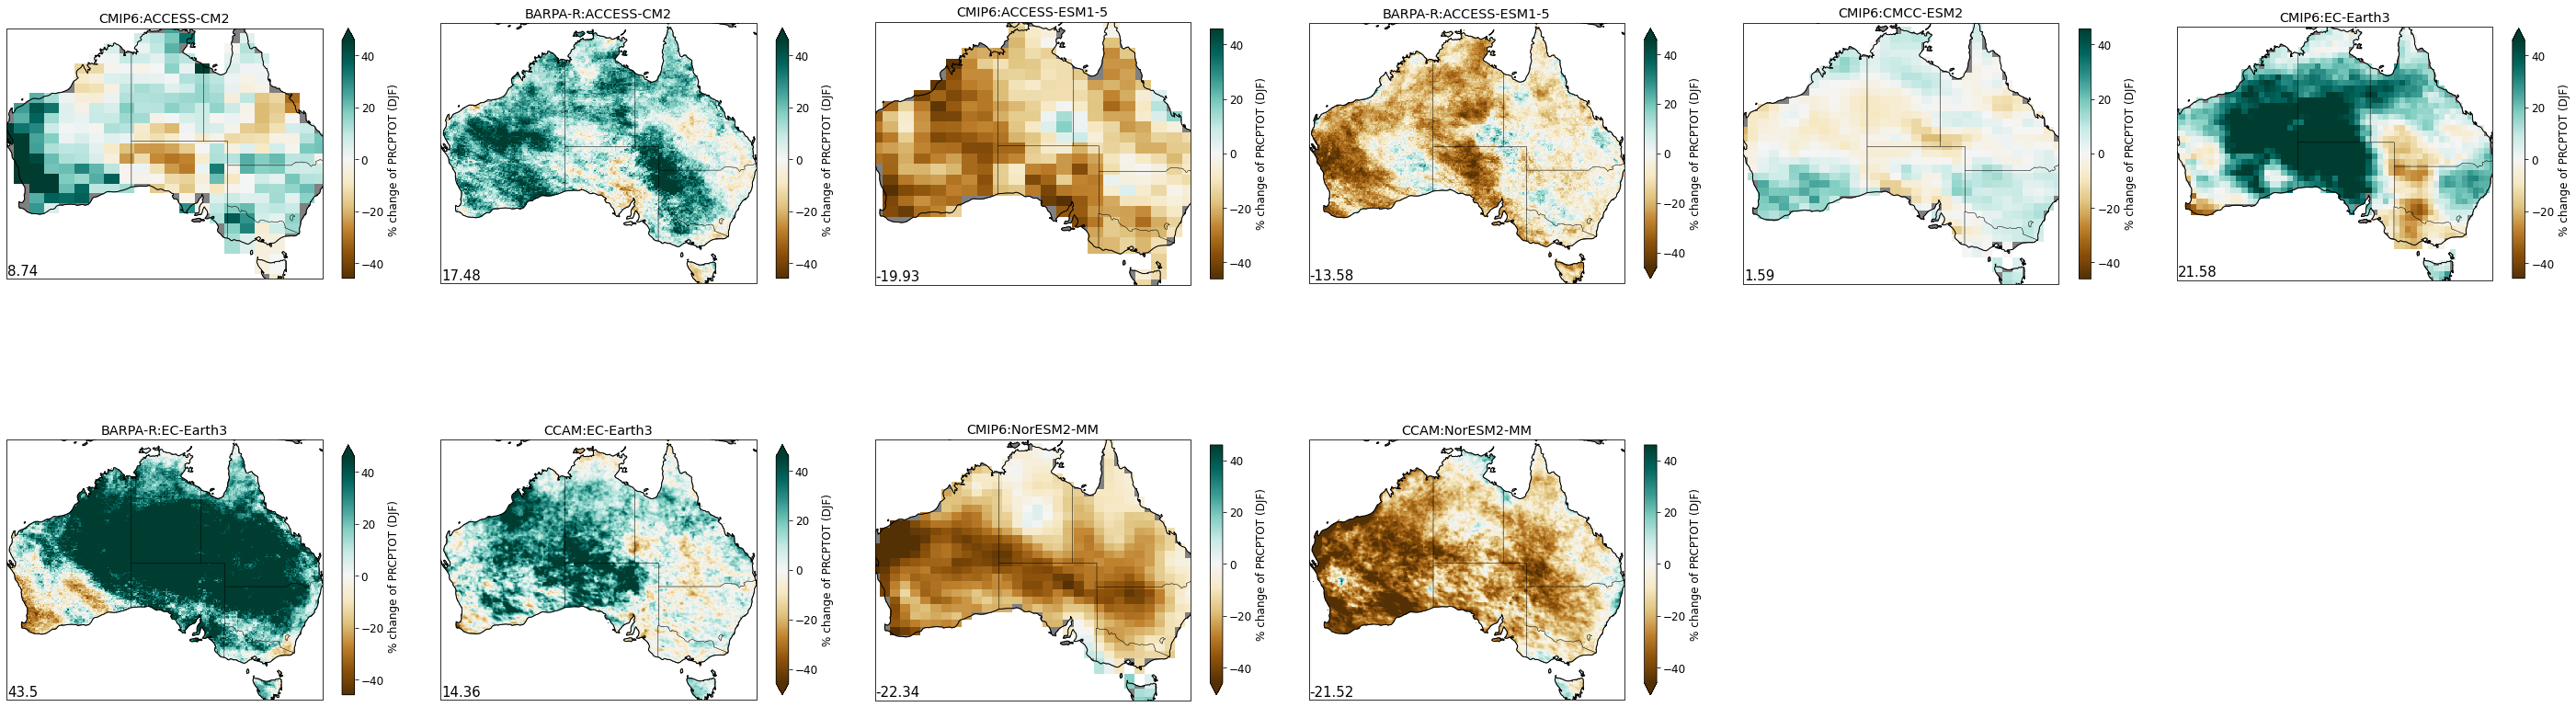

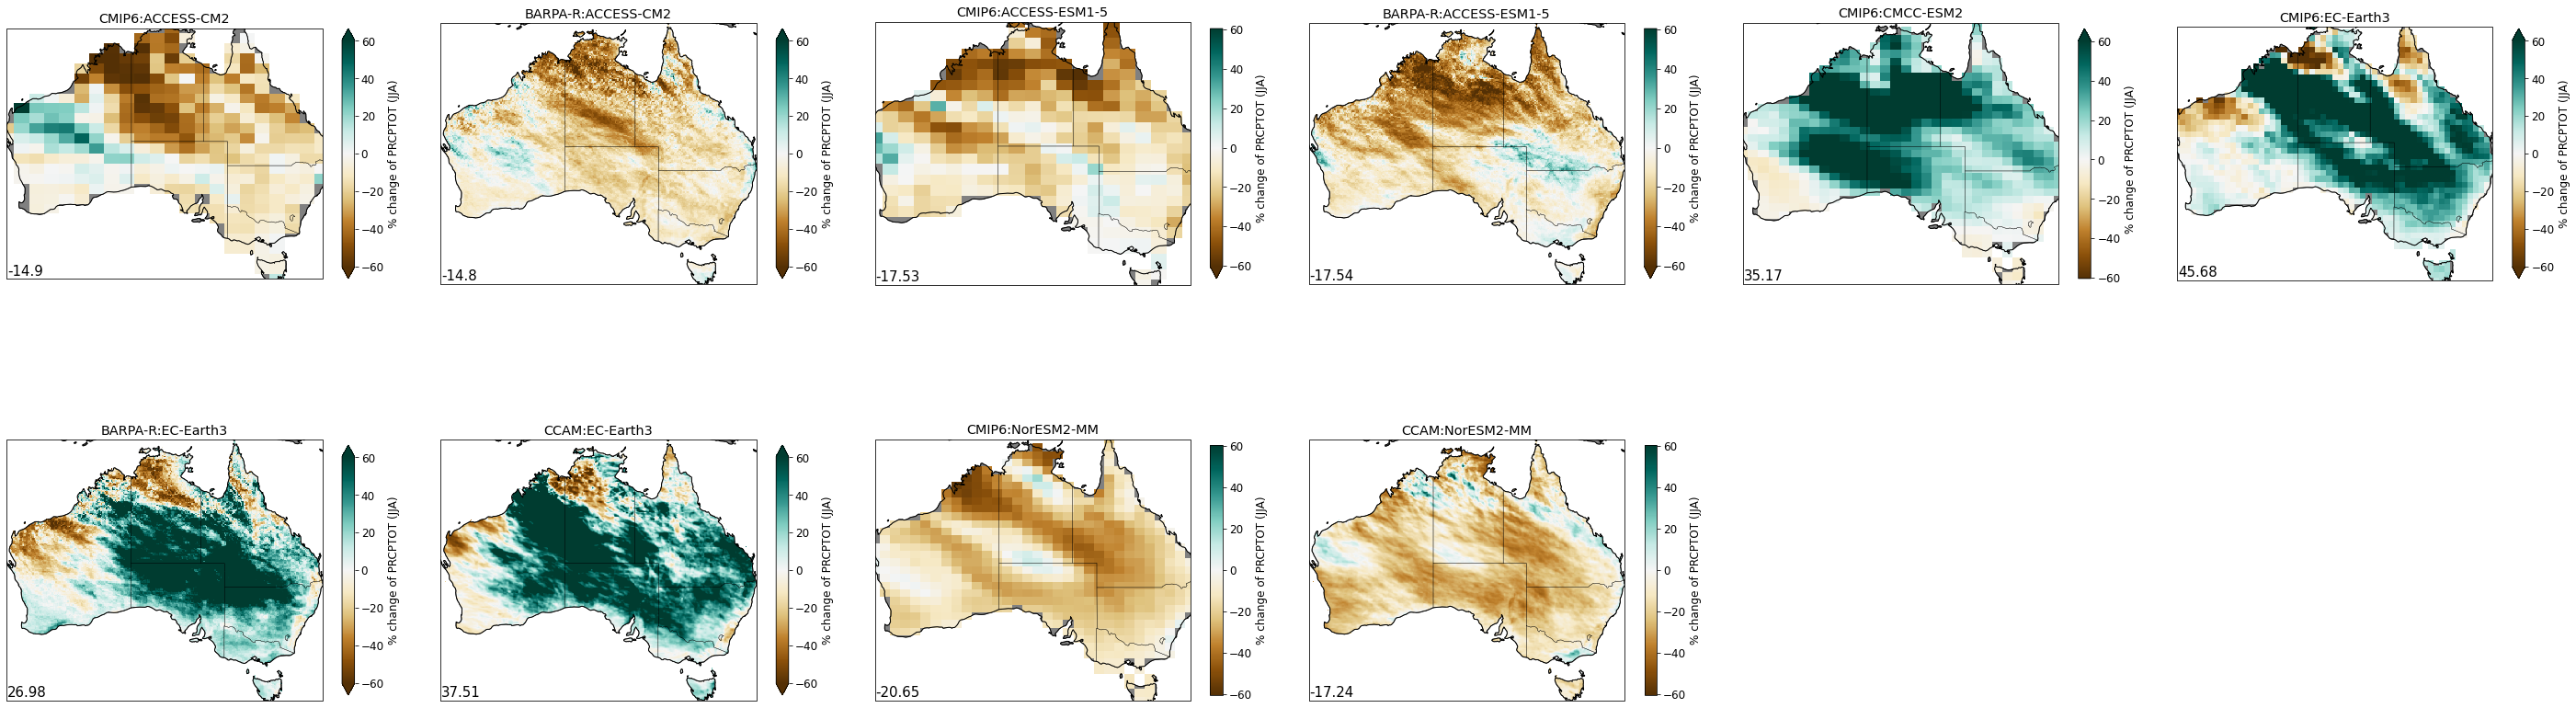

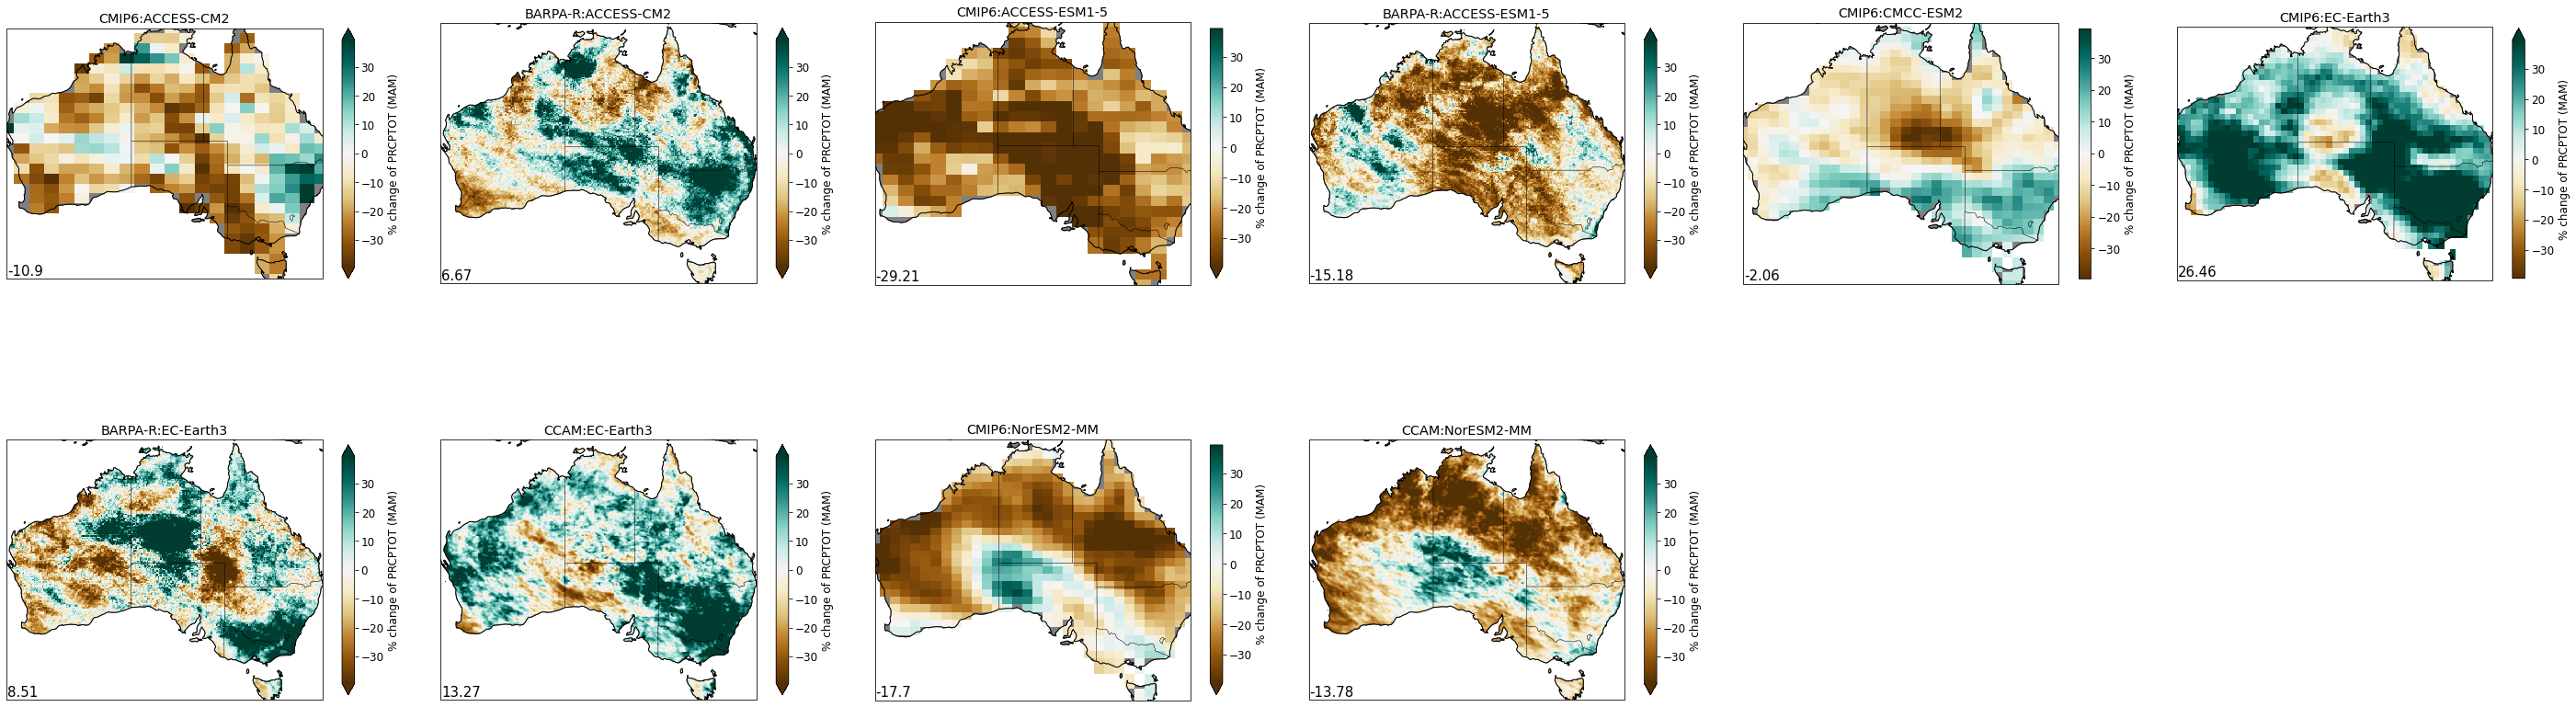

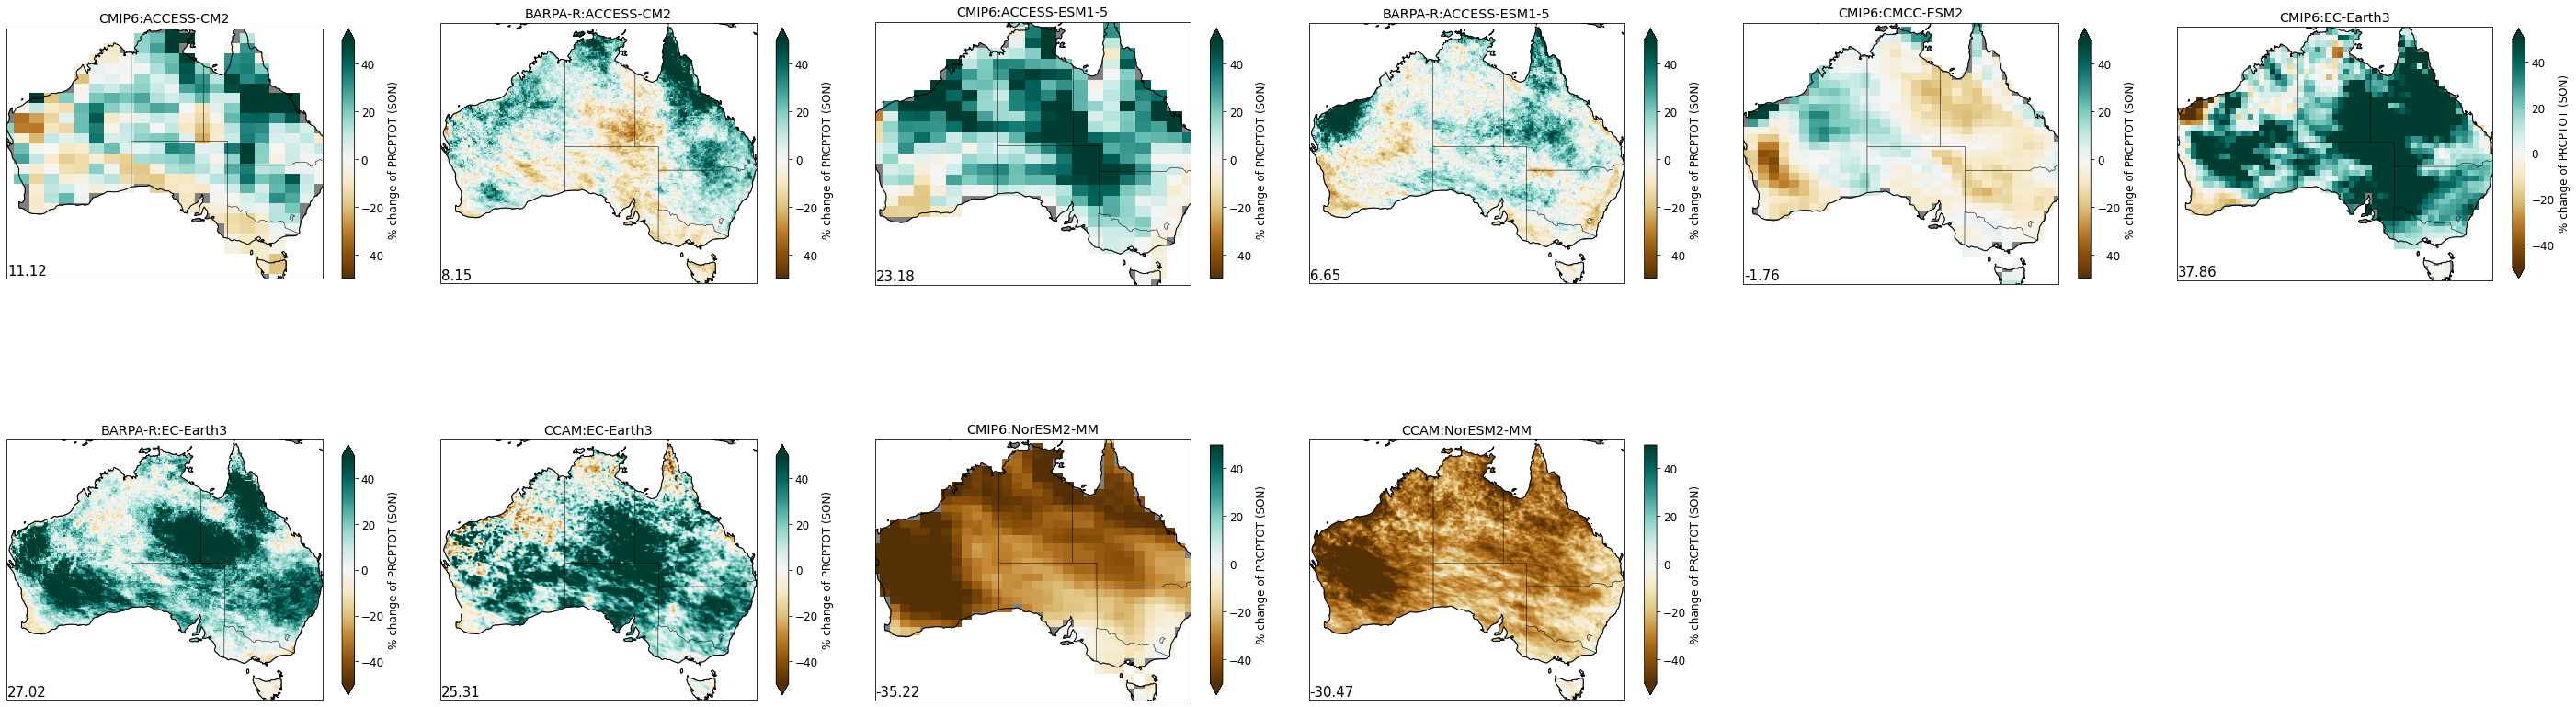

In [5]:
INDEXES = ['PRCPTOT', 'PRCPTOT:DJF', 'PRCPTOT:JJA', 'PRCPTOT:MAM', 'PRCPTOT:SON']
for index in INDEXES:
    print("index = {:}".format(index))
    
    # check whether the index has special conditions
    index_condition = None
    if not ":" in index:
        # Prepare all the icclim data as per the setup in CONFIGURATIONS
        ds0 = prepare_data_hist(index)
        ds1 = prepare_data_fut(index)
        clabel = "% change of {index} ({freq})".format(index=index, freq=FREQ)
    else:
        index_condition = index.split(":")[1]
        index = index.split(":")[0]
        ds0 = prepare_data_hist(index, season=index_condition)
        ds1 = prepare_data_fut(index, season=index_condition)
        clabel = "% change of {index} ({index_condition})".format(index=index, index_condition=index_condition)
    
    ds0_target = {}
    ds1_target = {}
    ds_target = {}
    flist = []
    for s0, s1 in zip(SOURCES_HIST, SOURCES_FUT):
        print(s0, s1)
        ds0_target[s0] = ds0[s0][index].mean(dim='time')
        ds0_target[s0] = lib_spatial.apply_region_mask(ds0_target[s0], 'Australia')
        ds1_target[s1] = ds1[s1][index].mean(dim='time')
        ds1_target[s1] = lib_spatial.apply_region_mask(ds1_target[s1], 'Australia')
        # no need to mask out agcd area
#        if 'PRCPTOT' in index:
#            ds0_target[s0] = lib_spatial.apply_agcd_data_mask(ds0_target[s0])
#            ds1_target[s1] = lib_spatial.apply_agcd_data_mask(ds1_target[s1])
        ds_target[s0] = (ds1_target[s1]-ds0_target[s0])/ds0_target[s0]*100 # percentage change
            
        # save min/max values into a flattened list to generate shared colourbar
        for sublist in ds_target[s0].values:
            for item in sublist:
                flist.append(item)
                
    if index in ['PRCPTOT']:
        cmap_variable = 'precip'
        cmap_class = 'wet_diff'
    
    flistnp = np.array(flist)
    lib_standards.spatial_plot_trend(ds_target, flistnp, cmap_variable=cmap_variable, cbar_shrink=0.6,
                                     cmap_class=cmap_class, clabel=clabel, include_area_avg=True,
                                     centre_colorbar=True, high_percentile=90, low_percentile=10, ncol=6, nrow=6)
    plt.tight_layout()
    plt.savefig("./figs/pr/ssp126_mid_minus_hist_pr_percentage_%s_%s.png"%(index,index_condition),dpi=300)

index = PRCPTOT
CMIP6:ACCESS-CM2 CMIP6:ACCESS-CM2
BARPA-R:ACCESS-CM2 BARPA-R:ACCESS-CM2
CMIP6:ACCESS-ESM1-5 CMIP6:ACCESS-ESM1-5
BARPA-R:ACCESS-ESM1-5 BARPA-R:ACCESS-ESM1-5
CMIP6:CMCC-ESM2 CMIP6:CMCC-ESM2
CMIP6:EC-Earth3 CMIP6:EC-Earth3
BARPA-R:EC-Earth3 BARPA-R:EC-Earth3
CCAM:EC-Earth3 CCAM:EC-Earth3
CMIP6:NorESM2-MM CMIP6:NorESM2-MM
CCAM:NorESM2-MM CCAM:NorESM2-MM
index = PRCPTOT:DJF
CMIP6:ACCESS-CM2 CMIP6:ACCESS-CM2
BARPA-R:ACCESS-CM2 BARPA-R:ACCESS-CM2
CMIP6:ACCESS-ESM1-5 CMIP6:ACCESS-ESM1-5
BARPA-R:ACCESS-ESM1-5 BARPA-R:ACCESS-ESM1-5
CMIP6:CMCC-ESM2 CMIP6:CMCC-ESM2
CMIP6:EC-Earth3 CMIP6:EC-Earth3
BARPA-R:EC-Earth3 BARPA-R:EC-Earth3
CCAM:EC-Earth3 CCAM:EC-Earth3
CMIP6:NorESM2-MM CMIP6:NorESM2-MM
CCAM:NorESM2-MM CCAM:NorESM2-MM
index = PRCPTOT:JJA
CMIP6:ACCESS-CM2 CMIP6:ACCESS-CM2
BARPA-R:ACCESS-CM2 BARPA-R:ACCESS-CM2
CMIP6:ACCESS-ESM1-5 CMIP6:ACCESS-ESM1-5
BARPA-R:ACCESS-ESM1-5 BARPA-R:ACCESS-ESM1-5
CMIP6:CMCC-ESM2 CMIP6:CMCC-ESM2
CMIP6:EC-Earth3 CMIP6:EC-Earth3
BARPA-R:EC-Earth3 BA

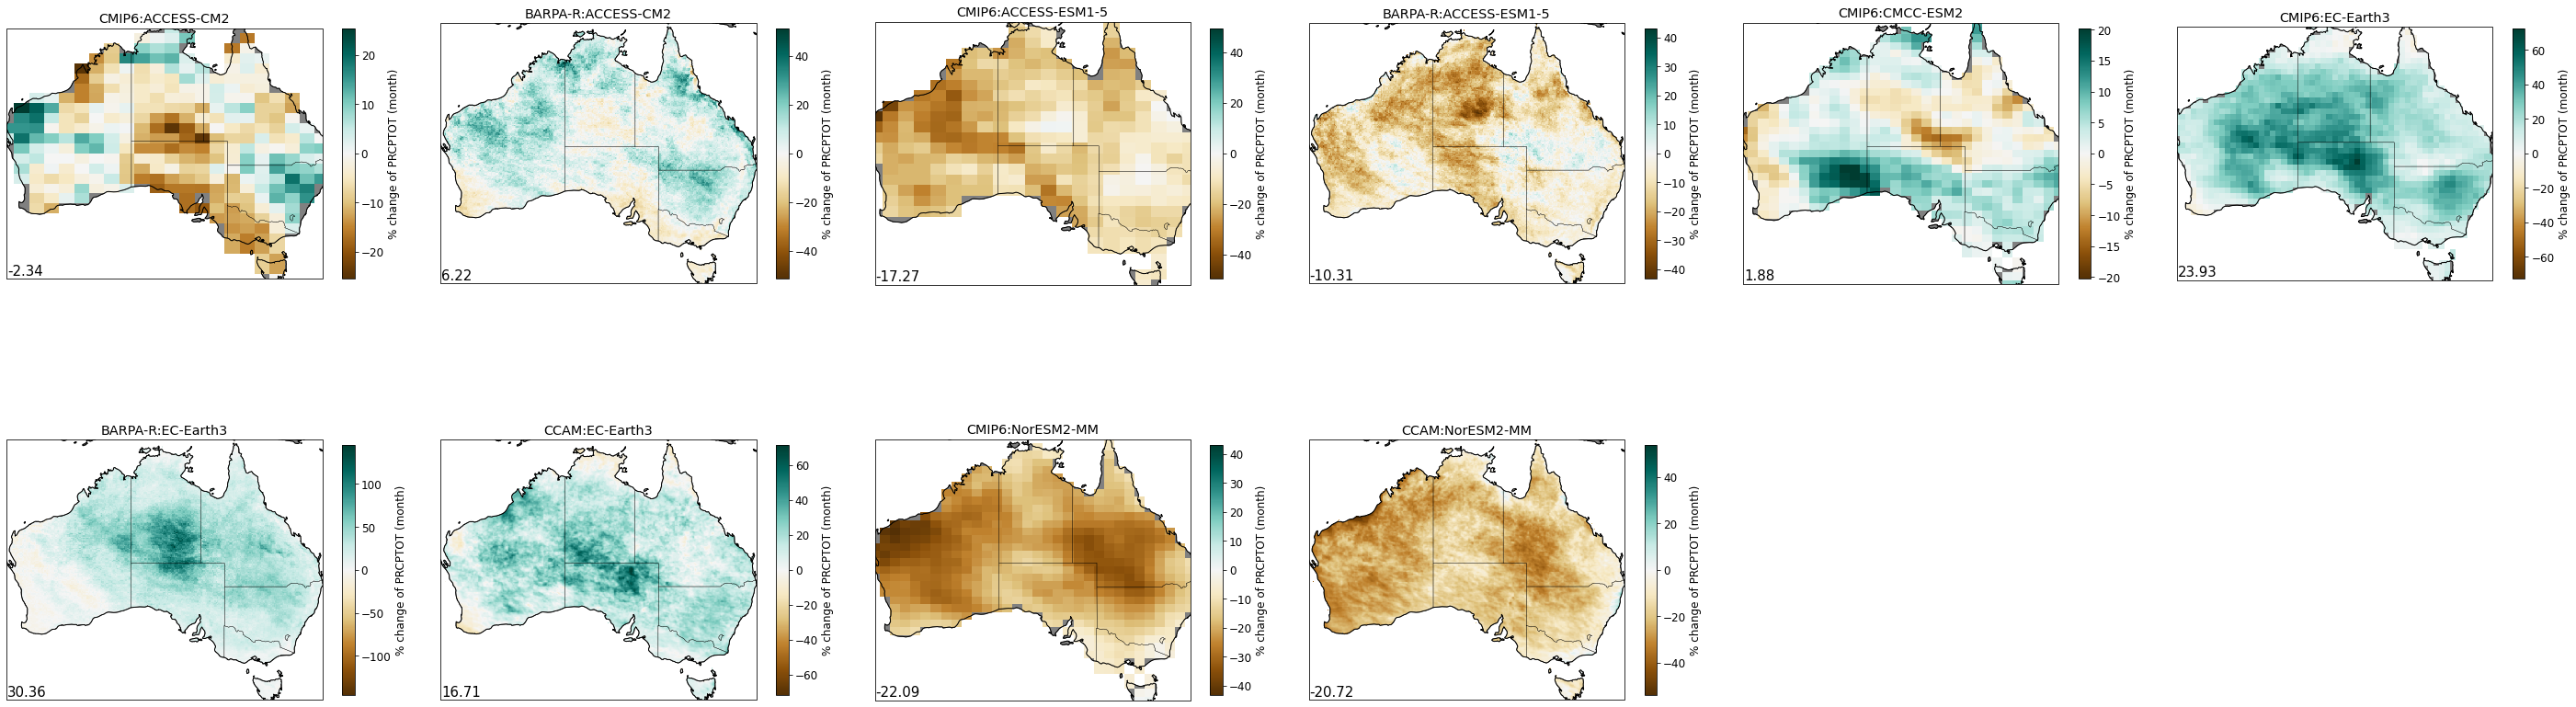

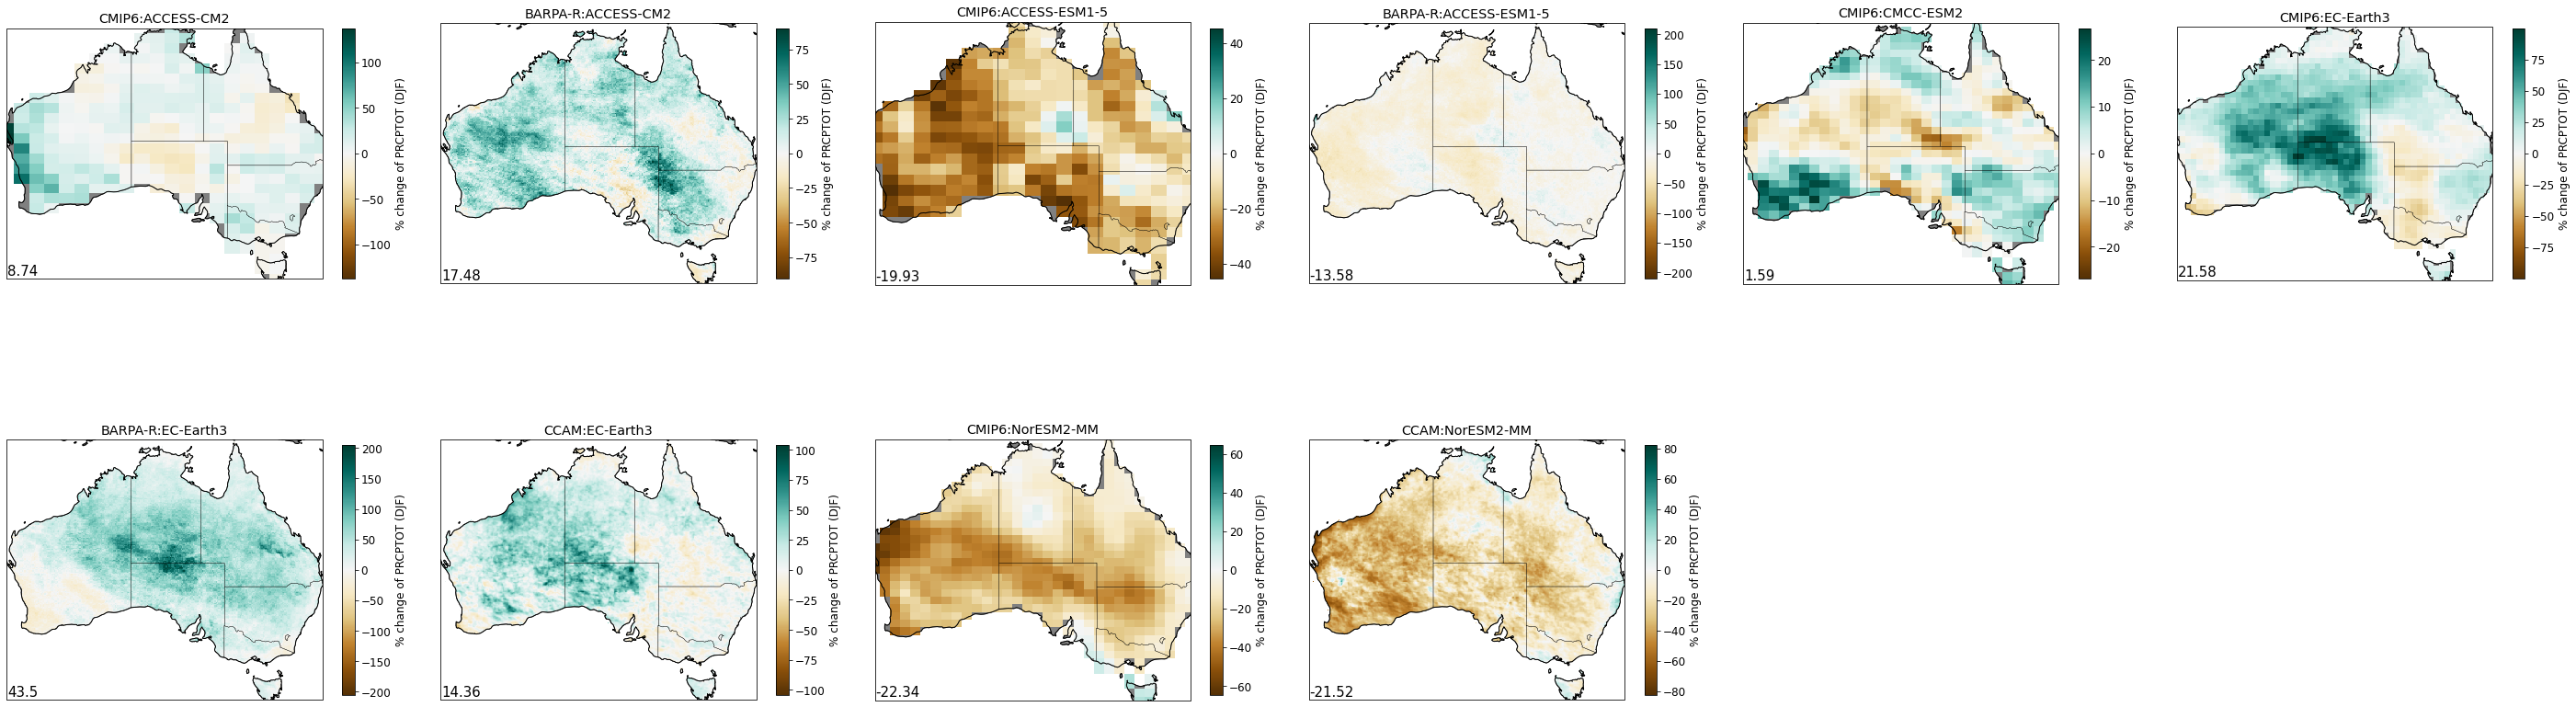

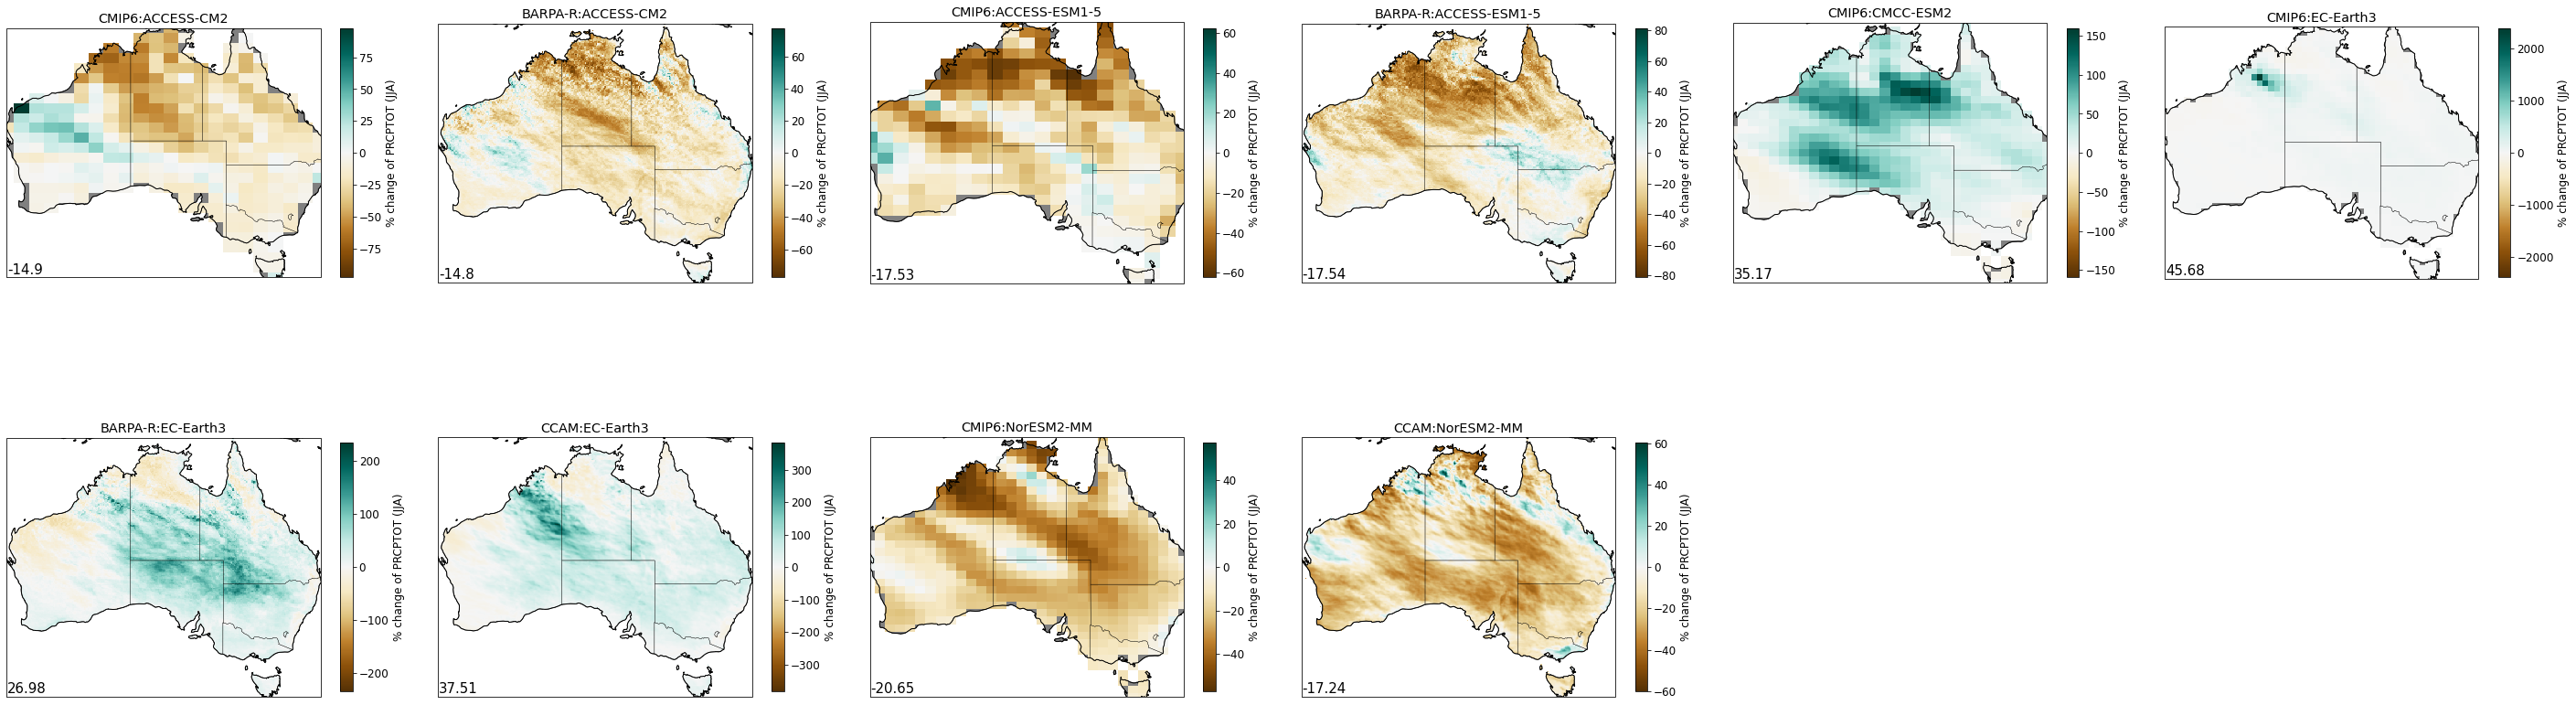

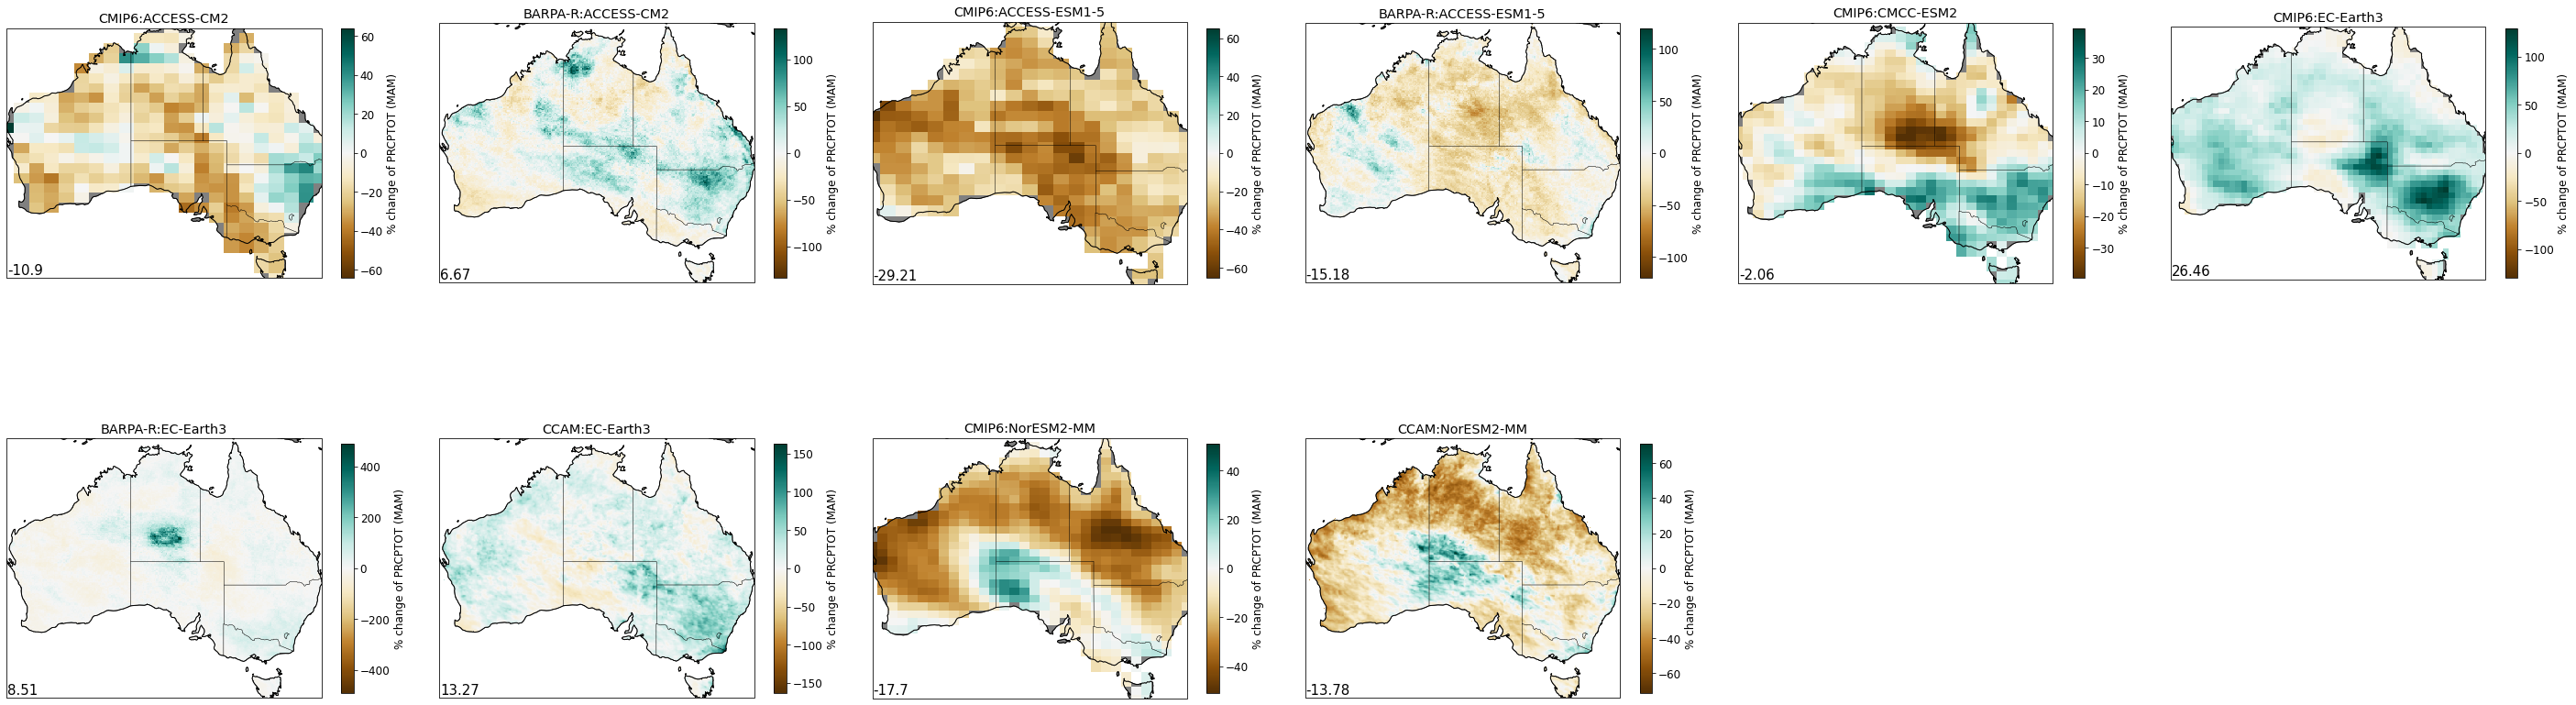

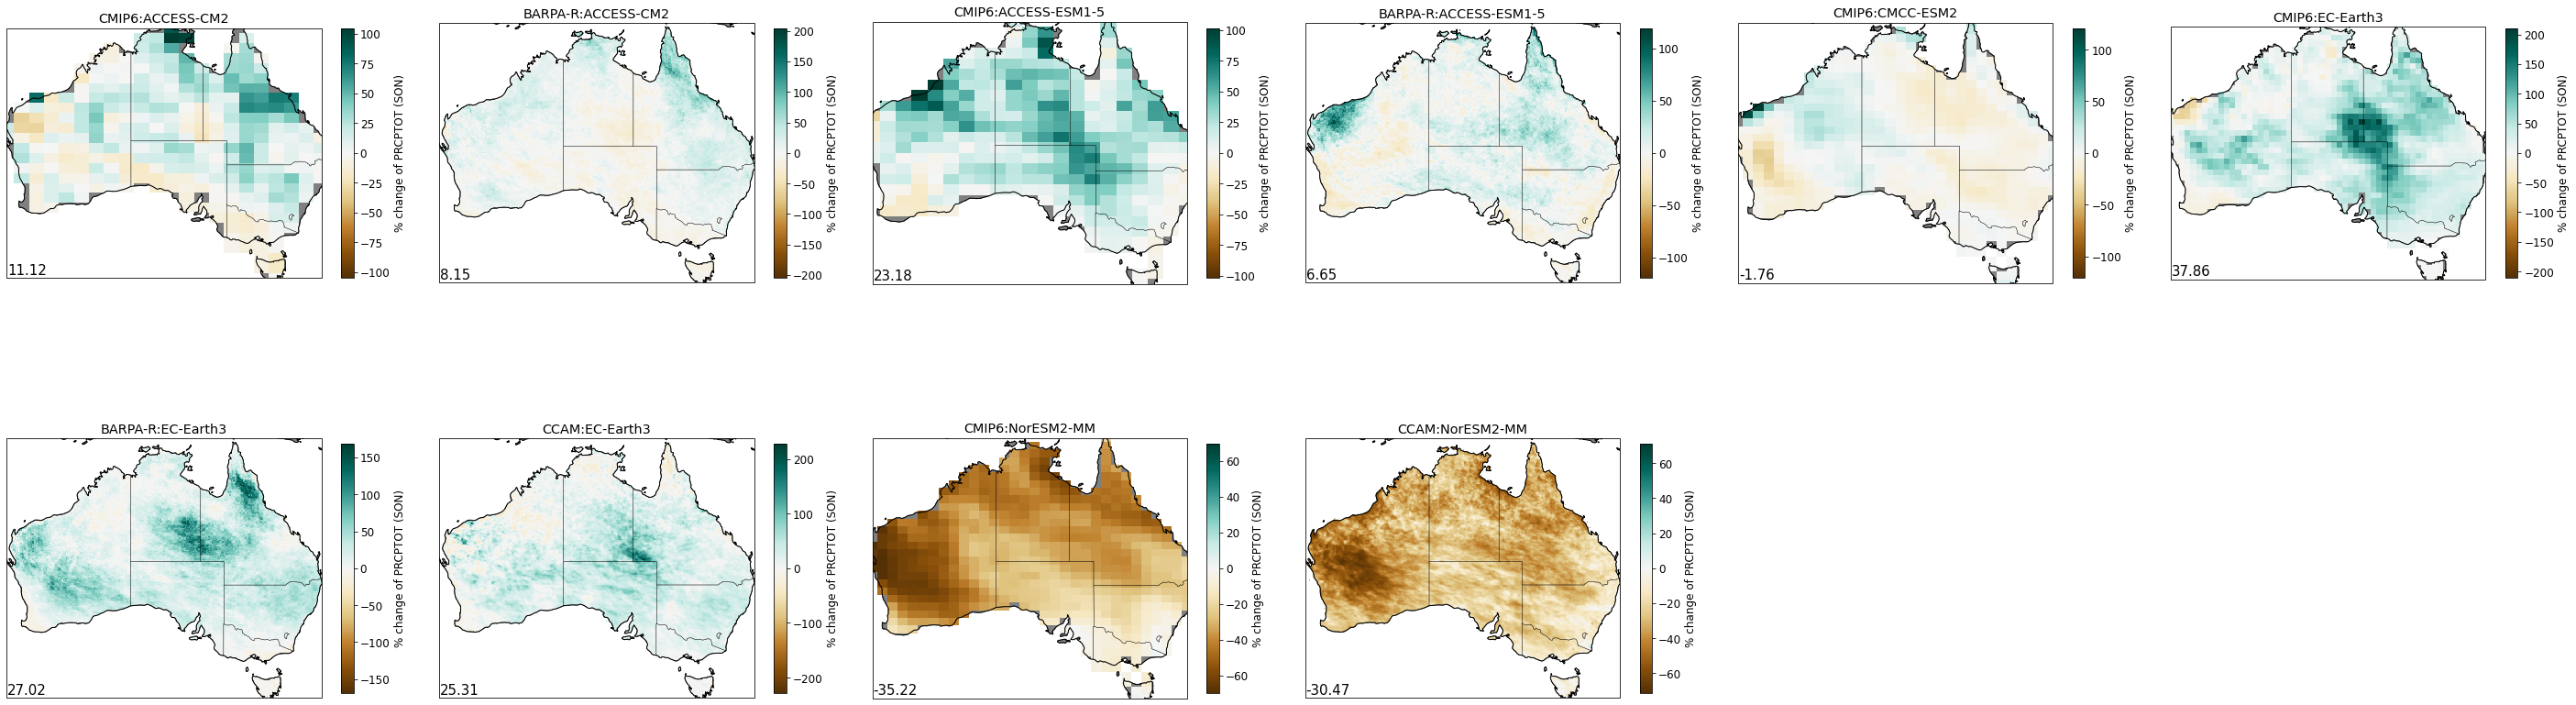

In [6]:
INDEXES = ['PRCPTOT', 'PRCPTOT:DJF', 'PRCPTOT:JJA', 'PRCPTOT:MAM', 'PRCPTOT:SON']
for index in INDEXES:
    print("index = {:}".format(index))
    
    # check whether the index has special conditions
    index_condition = None
    if not ":" in index:
        # Prepare all the icclim data as per the setup in CONFIGURATIONS
        ds0 = prepare_data_hist(index)
        ds1 = prepare_data_fut(index)
        clabel = "% change of {index} ({freq})".format(index=index, freq=FREQ)
    else:
        index_condition = index.split(":")[1]
        index = index.split(":")[0]
        ds0 = prepare_data_hist(index, season=index_condition)
        ds1 = prepare_data_fut(index, season=index_condition)
        clabel = "% change of {index} ({index_condition})".format(index=index, index_condition=index_condition)
    
    ds0_target = {}
    ds1_target = {}
    ds_target = {}
    flist = []
    for s0, s1 in zip(SOURCES_HIST, SOURCES_FUT):
        print(s0, s1)
        ds0_target[s0] = ds0[s0][index].mean(dim='time')
        ds0_target[s0] = lib_spatial.apply_region_mask(ds0_target[s0], 'Australia')
        ds1_target[s1] = ds1[s1][index].mean(dim='time')
        ds1_target[s1] = lib_spatial.apply_region_mask(ds1_target[s1], 'Australia')
        # no need to mask out agcd area
#        if 'PRCPTOT' in index:
#            ds0_target[s0] = lib_spatial.apply_agcd_data_mask(ds0_target[s0])
#            ds1_target[s1] = lib_spatial.apply_agcd_data_mask(ds1_target[s1])
        ds_target[s0] = (ds1_target[s1]-ds0_target[s0])/ds0_target[s0]*100 # percentage change
            
        # save min/max values into a flattened list to generate shared colourbar
        for sublist in ds_target[s0].values:
            for item in sublist:
                flist.append(item)
                
    if index in ['PRCPTOT']:
        cmap_variable = 'precip'
        cmap_class = 'wet_diff'
    
    flistnp = np.array(flist)
    lib_standards.spatial_plot_trend(ds_target, cmap_variable=cmap_variable, cbar_shrink=0.6,
                                     cmap_class=cmap_class, clabel=clabel, include_area_avg=True,
                                     centre_colorbar=True, high_percentile=90, low_percentile=10, ncol=6, nrow=6)
    plt.tight_layout()
    plt.savefig("./figs/pr/ssp126_mid_minus_hist_pr_percentage_individual_colorbar_%s_%s.png"%(index,index_condition),dpi=300)

In [7]:
# # regrid all data to ccam grid
# def prepare_data_hist(index, sources=SOURCES_HIST, freq=FREQ, region=REGION, period=EARLYPERIOD, reference_grid=REFERENCE_GRID, season=SEASON):
#     """
#     Reads in the icclim data and regrid to the reference grid.
#     """
#     # Load the data sources
#     ds = {}
#     for s in sources:
#         #print("Reading the data {:}".format(s))
#         fs = glob.glob(os.path.join(DATA_LOCATIONS_HIST[s], index, "{index}_*_{freq}_*.nc".format(index=index, freq=freq)))
#         #print(fs)
#         ds[s] = xr.open_dataset(fs[0])
#         ds[s] = lib_standards.standardise_data(ds[s], region=region, period=period, season=season, compute=True)

#     # Regrid to the REFERENCE_GRID
#     ds_regrid = {}
#     for s in sources:
#         #print("Regridding the data {:} to reference grid of {:}".format(s, reference_grid))
#         #ds_regrid[s] = lib_spatial.add_region_land_mask(ds[s], region)
#         ds_regrid[s] = ds[s]
#         if s == reference_grid:
#             ds_regrid[s] = ds_regrid[s].compute()
#         else:
#             ds_regrid[s] = lib_standards.regrid(ds_regrid[s], ds[reference_grid]).compute()
#     return ds_regrid

In [8]:
# # regrid all data to ccam grid
# def prepare_data_fut(index, sources=SOURCES_FUT, freq=FREQ, region=REGION, period=LATEPERIOD, reference_grid=REFERENCE_GRID, season=SEASON):
#     """
#     Reads in the icclim data and regrid to the reference grid.
#     """
#     # Load the data sources
#     ds = {}
#     for s in sources:
#         #print("Reading the data {:}".format(s))
#         fs = glob.glob(os.path.join(DATA_LOCATIONS_FUT[s], index, "{index}_*_{freq}_*.nc".format(index=index, freq=freq)))
#         #print(fs[0])
#         ds[s] = xr.open_dataset(fs[0])
#         ds[s] = lib_standards.standardise_data(ds[s], region=region, period=period, season=season, compute=True)

#     # Regrid to the REFERENCE_GRID
#     ds_regrid = {}
#     for s in sources:
#         #print("Regridding the data {:} to reference grid of {:}".format(s, reference_grid))
#         #ds_regrid[s] = lib_spatial.add_region_land_mask(ds[s], region)
#         ds_regrid[s] = ds[s]
#         if s == reference_grid:
#             ds_regrid[s] = ds_regrid[s].compute()
#         else:
#             ds_regrid[s] = lib_standards.regrid(ds_regrid[s], ds[reference_grid]).compute()
#     return ds_regrid

In [9]:
# INDEXES = ['PRCPTOT', 'PRCPTOT:DJF', 'PRCPTOT:JJA', 'PRCPTOT:MAM', 'PRCPTOT:SON']
# for index in INDEXES:
#     print("index = {:}".format(index))
    
#     # check whether the index has special conditions
#     index_condition = None
#     if not ":" in index:
#         # Prepare all the icclim data as per the setup in CONFIGURATIONS
#         ds0 = prepare_data_hist(index)
#         ds1 = prepare_data_fut(index)
#         clabel = "% change of {index} ({freq})".format(index=index, freq=FREQ)
#     else:
#         index_condition = index.split(":")[1]
#         index = index.split(":")[0]
#         ds0 = prepare_data_hist(index, season=index_condition)
#         ds1 = prepare_data_fut(index, season=index_condition)
#         clabel = "% change of {index} ({index_condition})".format(index=index, index_condition=index_condition)
    
#     ds0_target = {}
#     ds1_target = {}
#     ds_target = {}
#     flist = []
#     for s0, s1 in zip(SOURCES_HIST, SOURCES_FUT):
#         print(s0, s1)
#         ds0_target[s0] = ds0[s0][index].mean(dim='time')
#         ds0_target[s0] = lib_spatial.apply_region_mask(ds0_target[s0], 'Australia')
#         ds1_target[s1] = ds1[s1][index].mean(dim='time')
#         ds1_target[s1] = lib_spatial.apply_region_mask(ds1_target[s1], 'Australia')
#         # no need to mask out agcd area
# #        if 'PRCPTOT' in index:
# #            ds0_target[s0] = lib_spatial.apply_agcd_data_mask(ds0_target[s0])
# #            ds1_target[s1] = lib_spatial.apply_agcd_data_mask(ds1_target[s1])
#         ds_target[s0] = (ds1_target[s1]-ds0_target[s0])/ds0_target[s0]*100 # percentage change
            
#         # save min/max values into a flattened list to generate shared colourbar
#         for sublist in ds_target[s0].values:
#             for item in sublist:
#                 flist.append(item)
                
#     if index in ['PRCPTOT']:
#         cmap_variable = 'precip'
#         cmap_class = 'wet_diff'
    
#     flistnp = np.array(flist)
#     lib_standards.spatial_plot_trend(ds_target, flistnp, cmap_variable=cmap_variable,
#                                      cmap_class=cmap_class, clabel=clabel, include_area_avg=True,
#                                      centre_colorbar=True, high_percentile=90, low_percentile=10)
#     plt.tight_layout()
#     plt.savefig("./figs/pr/ssp126_mid_minus_hist_pr_percentage_regrid_%s_%s.png"%(index,index_condition),dpi=300)